In [182]:
from sentence_transformers import SentenceTransformer, util
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

In [183]:
import matplotlib.pyplot as plt
from PIL import Image  # Para carregar imagens
import pandas as pd
import numpy as np

def plot_image(image_path):
    """
    Função para plotar uma imagem a partir de um caminho.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [184]:
# Load LDA
import pickle

with open('lda_model_cor.pkl', 'rb') as f:
    lda_model = pickle.load(f)

In [185]:
lda_model

LinearDiscriminantAnalysis(n_components=10)

In [186]:
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

In [187]:
# Puxando base.parquet
df = pd.read_parquet('datasets/base.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 765
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_path            766 non-null    object
 1   id_produto           766 non-null    object
 2   grupo_produto        766 non-null    object
 3   file_name            766 non-null    object
 4   link                 766 non-null    object
 5   PRODUTOS             766 non-null    object
 6   CARACTERISTICAS      766 non-null    object
 7   LOCALIZACAO_ESTAMPA  766 non-null    object
 8   COR_PREDOMINANTE     766 non-null    object
 9   DECOTE_OU_GOLA       515 non-null    object
 10  COMPRIMENTO_SAIA     216 non-null    object
 11  AMARRACAO            748 non-null    object
 12  ZOOM_ESTAMPA         766 non-null    object
 13  COMPRIMENTO_MANGA    533 non-null    object
 14  ESTILO               766 non-null    object
 15  TIPO_MANGA           533 non-null    object
 16  TIPO_CIN

In [188]:
# Sample 10 blusas vermelhas
sample_camisetas = df[(df['COR_PREDOMINANTE'] == 'VERDE') & (df['grupo_produto'] == 'blusa')].sample(10)

In [189]:
# Adicionar 52-06-0723-04331 ao sample
sample_camisetas = sample_camisetas.append(df[df['id_produto'] == '52-06-0723-04331'])
sample_camisetas = sample_camisetas.append(df[df['id_produto'] == '52-06-0713-0005'])

C:\Users\Cole\AppData\Local\Temp\ipykernel_30028\4243317563.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_camisetas = sample_camisetas.append(df[df['id_produto'] == '52-06-0723-04331'])
C:\Users\Cole\AppData\Local\Temp\ipykernel_30028\4243317563.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_camisetas = sample_camisetas.append(df[df['id_produto'] == '52-06-0713-0005'])


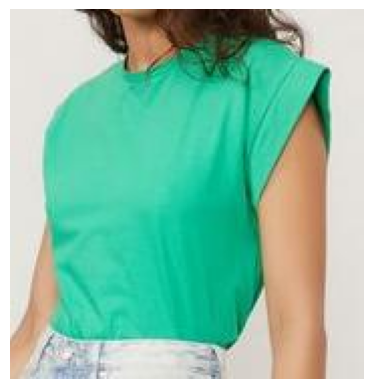

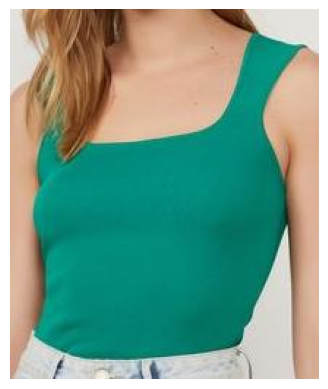

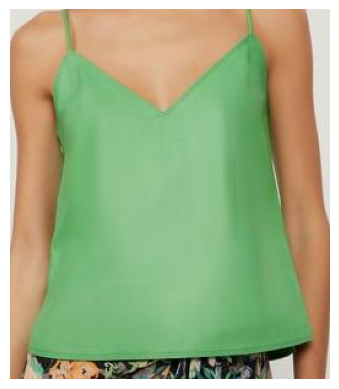

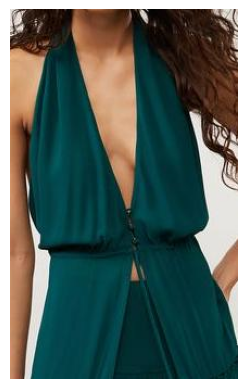

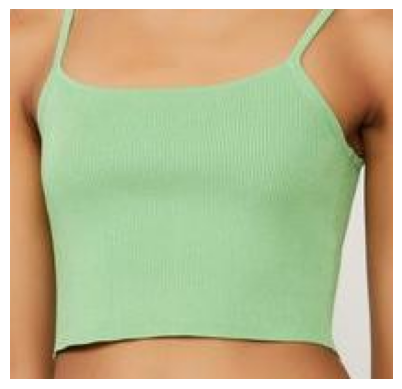

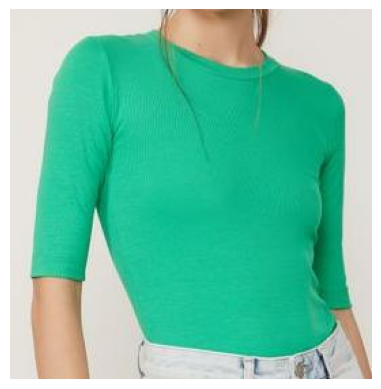

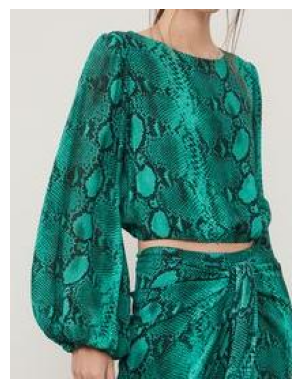

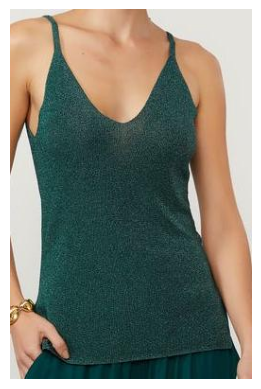

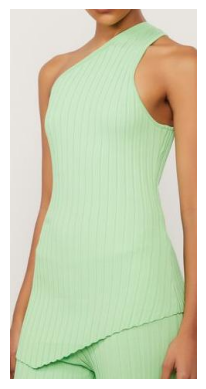

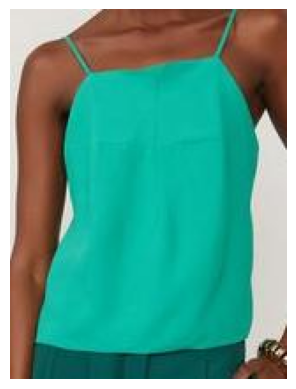

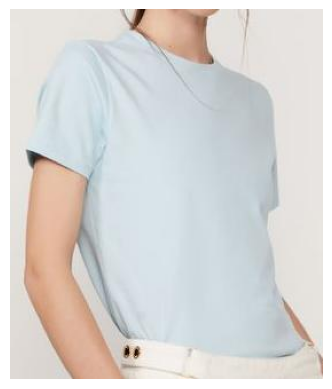

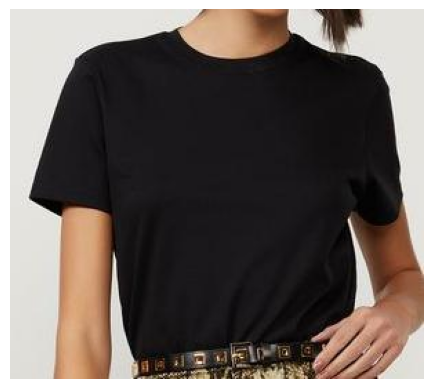

In [190]:
for i in range(len(sample_camisetas)):
    plot_image(sample_camisetas.iloc[i]['file_path'])

In [191]:
df.columns

Index(['file_path', 'id_produto', 'grupo_produto', 'file_name', 'link',
       'PRODUTOS', 'CARACTERISTICAS', 'LOCALIZACAO_ESTAMPA',
       'COR_PREDOMINANTE', 'DECOTE_OU_GOLA', 'COMPRIMENTO_SAIA', 'AMARRACAO',
       'ZOOM_ESTAMPA', 'COMPRIMENTO_MANGA', 'ESTILO', 'TIPO_MANGA',
       'TIPO_CINTURA', 'COMPRIMENTO', 'MODELAGEM', 'ESTAMPA', 'FENDA_PERNA',
       'MODELAGEM_SAIA', 'TIPO_BARRA', 'desc_produto'],
      dtype='object')

In [192]:
# Carregando embeddings
df_embs = pd.read_parquet('datasets/img_embeddings.parquet')

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

emb_columns = [col for col in df_embs.columns if 'emb' in col]
pca = PCA(n_components=80)
pca_roupas = pca.fit_transform(df_embs[emb_columns])

In [193]:
pca_roupas.shape

(766, 80)

In [194]:
lda = LDA(n_components=10)
lda_cor = lda.fit_transform(pca_roupas, df['COR_PREDOMINANTE'])

In [195]:
lda_cor.shape

(766, 10)

In [196]:
sample_camisetas = pd.merge(sample_camisetas, df_embs, on='id_produto', how='left')

In [197]:
emb_columns = [col for col in sample_camisetas.columns if col.startswith('emb_img_')]

In [198]:
from sklearn.metrics.pairwise import cosine_similarity

# Função que recebe o embedding de uma imagem e retorna
# um dataframe com o id e a similaridade de cosseno com cada id de sample_camisetas
def get_cosine_similarity(embedding):
    cos_sim = cosine_similarity([embedding], sample_camisetas[emb_columns])
    cos_sim = cos_sim[0]
    cos_sim_df = pd.DataFrame({'id_produto': sample_camisetas['id_produto'], 'cosine_similarity': cos_sim})
    return cos_sim_df

# # Exemplos: Calculando similaridade de cosseno para a primeira imagem
# cos_sim_df = get_cosine_similarity(sample_camisetas.iloc[0][emb_columns])

In [199]:
# Load the image
img = load_image('teste_camiseta_verde.png')

# Encode the image
test_img_embedding = img_model.encode(img)

Similaridades antes de usar o LDA pra tirar o subespaço de cor.

In [200]:
# Comparando com as imagens de exemplo
cos_sim_df = get_cosine_similarity(test_img_embedding)
cos_sim_df

,id_produto,cosine_similarity
0,52-06-0693-09258,0.844340
1,52-15-1376-09255,0.877446
2,52-15-1397-09258,0.898774
3,52-13-5370-09253,0.794942
4,52-15-1526-04113,0.830628
5,52-06-0688-09258,0.873439
6,52-13-5433-09539,0.814494
7,52-15-1344-09253,0.872235
8,52-13-5563-04113,0.856092
9,52-10-5199-03344,0.853532


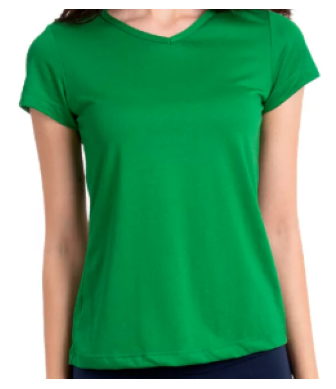

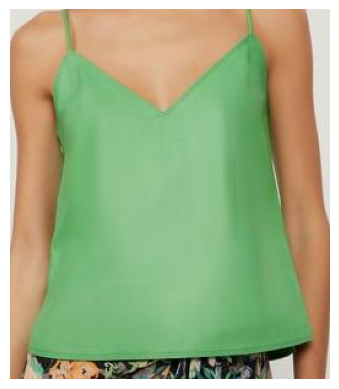

ID do produto: 52-15-1397-09258
Similaridade de cosseno: 0.898774266242981


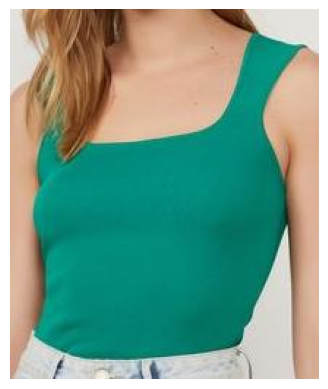

ID do produto: 52-15-1376-09255
Similaridade de cosseno: 0.877446174621582


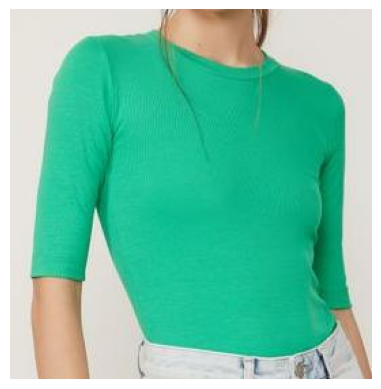

ID do produto: 52-06-0688-09258
Similaridade de cosseno: 0.8734388947486877


In [201]:
# Load image teste_camiseta_verde.png
plot_image('teste_camiseta_verde.png')# Plotar as 5 imagens mais similares

for id in cos_sim_df.sort_values(by='cosine_similarity', ascending=False).head(3)['id_produto']:
    plot_image(sample_camisetas[sample_camisetas['id_produto'] == id]['file_path'].values[0])
    print(f"ID do produto: {id}")
    print(f"Similaridade de cosseno: {cos_sim_df[cos_sim_df['id_produto'] == id]['cosine_similarity'].values[0]}")


In [202]:
lda_model

LinearDiscriminantAnalysis(n_components=10)

In [203]:
# direcao_de_ser_estampado tem dimensão (512 x C-1), onde C é o número de classes do lda

# Normalize os vetores da base
B = lda.scalings_
B = B / np.linalg.norm(B, axis=0)

# C = lda_estampa.scalings_
# C = C / np.linalg.norm(C, axis=0)

# Projeção para remover viés de cor
def remove_bias(X, B):
    # Projeta X na base B e remove a projeção
    projection = B @ np.linalg.inv(B.T @ B) @ B.T @ X.T
    return (X.T - projection).T

# def remove_all_biases(X, list_bias):
#     # Remove todos os vetores de viés
#     for bias in list_bias:
#         X = remove_bias(X, bias)
#     return X

In [204]:
def get_cosine_similarity_without_bias(embedding):
    new_emb = pca.transform(embedding.reshape(1, -1))
    new_emb = remove_bias(new_emb, B)
    pca_roupas = pca.transform(sample_camisetas[emb_columns])
    pca_roupas = remove_bias(pca_roupas, B)
    cos_sim = cosine_similarity(new_emb, pca_roupas)
    cos_sim = cos_sim[0]
    cos_sim_df = pd.DataFrame({'id_produto': sample_camisetas['id_produto'], 'cosine_similarity': cos_sim})
    print(f"Emb1 shape: {new_emb.shape}, Emb2 shape: {pca_roupas.shape}")
    return cos_sim_df

def get_euclidean_distance_withou_bias(embedding):
    new_emb = pca.transform(embedding.reshape(1, -1))
    new_emb = remove_bias(new_emb, B)
    pca_roupas = pca.transform(sample_camisetas[emb_columns])
    pca_roupas = remove_bias(pca_roupas, B)
    euclidean_distances = np.linalg.norm(new_emb - pca_roupas, axis=1)
    euclidean_distances = euclidean_distances
    euclidean_distances_df = pd.DataFrame({'id_produto': sample_camisetas['id_produto'], 'euclidean_distance': euclidean_distances})
    print(f"Emb1 shape: {new_emb.shape}, Emb2 shape: {pca_roupas.shape}")
    return euclidean_distances_df

# Comparando com as imagens de exemplo
# cos_sim_df_bias = get_cosine_similarity_without_bias(test_img_embedding)
distances_df_bias = get_euclidean_distance_withou_bias(test_img_embedding)
distances_df_bias

Emb1 shape: (1, 80), Emb2 shape: (12, 80)


c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,id_produto,euclidean_distance
0,52-06-0693-09258,5.433660
1,52-15-1376-09255,4.737793
2,52-15-1397-09258,4.238691
3,52-13-5370-09253,6.401216
4,52-15-1526-04113,5.712135
5,52-06-0688-09258,4.868459
6,52-13-5433-09539,6.164577
7,52-15-1344-09253,4.840474
8,52-13-5563-04113,5.070056
9,52-10-5199-03344,5.303753


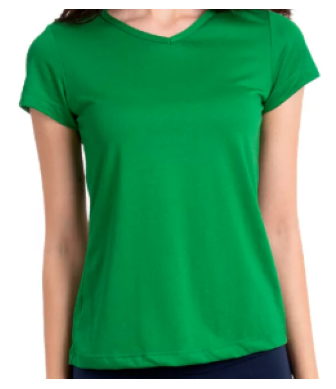

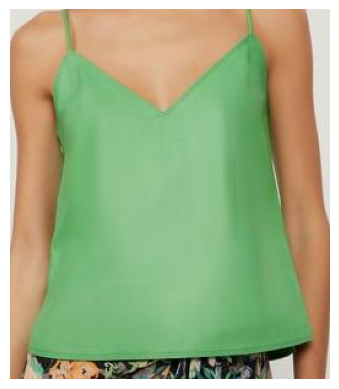

ID do produto: 52-15-1397-09258
euclidean_distance: 4.238691088881782


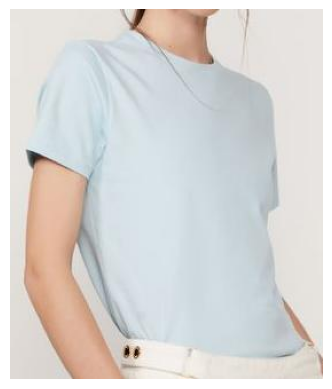

ID do produto: 52-06-0723-04331
euclidean_distance: 4.436767258169639


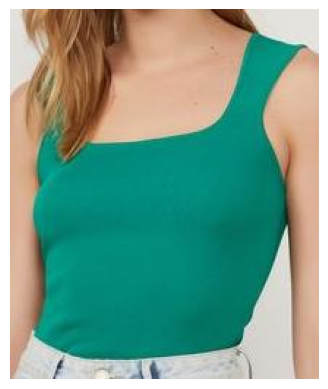

ID do produto: 52-15-1376-09255
euclidean_distance: 4.737793190017517


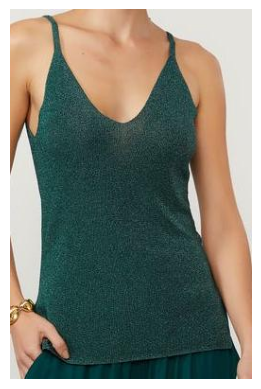

ID do produto: 52-15-1344-09253
euclidean_distance: 4.840473668281279


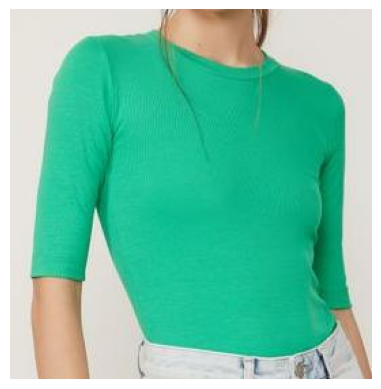

ID do produto: 52-06-0688-09258
euclidean_distance: 4.868458596475917


In [205]:
# Load image teste_camiseta_verde.png
plot_image('teste_camiseta_verde.png')# Plotar as 5 imagens mais similares

for id in distances_df_bias.sort_values(by='euclidean_distance', ascending=True).head(5)['id_produto']:
    plot_image(sample_camisetas[sample_camisetas['id_produto'] == id]['file_path'].values[0])
    print(f"ID do produto: {id}")
    print(f"euclidean_distance: {distances_df_bias[distances_df_bias['id_produto'] == id]['euclidean_distance'].values[0]}")